# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import os
from torch.optim import lr_scheduler
from pathlib import Path
from sklearn.model_selection import KFold

BATCH_SIZE = 32
# For implementation of ReLock
labels_holdout = []
info_holdout = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [3]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        size = int(X_batch.shape[1]/ 2)
        antenna1 = X_batch[:,:size]
        antenna2 = X_batch[:,size:]
        y_pred = model(antenna1, antenna2)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [4]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            size = int(X_batch.shape[1]/ 2)
            antenna1 = X_batch[:,:size]
            antenna2 = X_batch[:,size:]

            y_test_pred = model(antenna1, antenna2)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [6]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [7]:
def eval_model_3d(model: torch.nn.Module, 
                  data_loader: torch.utils.data.DataLoader, 
                  scaler,
                  device: torch.device = 'cpu',
                  verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            size = int(X.shape[1]/ 2)
            antenna1 = X[:,:size]
            antenna2 = X[:,size:]
            y_pred = model(antenna1, antenna2)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        number_of_points = 20

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=100
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=100
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()
        ax.grid(True)

        # Show the plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item()
    }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [8]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [9]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_Double_Antenna_1') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

# Holdout test withour permutations
holdout_dataset = np.load(f"{parent_dir}\\holdout_tensor.npy")
holdout_labels = np.load(f"{parent_dir}\\holdout_labels.npy")

info_tensor.shape , rfid_label.shape, holdout_dataset.shape, holdout_labels.shape

((2196, 500, 8), (2196, 3), (50, 500, 8), (50, 3))

In [10]:
print(info_tensor[:,:,6])

[[107.3 107.3 107.3 ... 107.3 107.3 107.3]
 [ 63.3  63.3  63.3 ...  63.3  63.3  63.3]
 [107.3 107.3 107.3 ... 107.3 107.3 107.3]
 ...
 [ 63.3  63.3  63.3 ...  63.3  63.3  63.3]
 [107.3 107.3 107.3 ... 107.3 107.3 107.3]
 [152.8 152.8 152.8 ... 152.8 152.8 152.8]]


Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [11]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(4000, 3)

In [12]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [13]:
def data_func_cv(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :]
    y_test = labels[val_idx, :]

    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [14]:
def cross_validation(input_array, labels, holdout_input, holdout_label, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):
    '''
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    labels_holdout = y_holdout
    info_holdout = X_holdout
    ####################################################
    '''
    X_main, X_holdout = input_array, holdout_input
    y_main, y_holdout = labels, holdout_label

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result, final_model

***

## Siamese Network

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(SiameseNetwork, self).__init__()
        
        # Shared feature extractor
        self.shared_network = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units//2),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units//2, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features=hidden_units ),   
        )
        
        # Fully connected layers after feature extraction
        self.fc = nn.Sequential(
            nn.Linear(hidden_units, hidden_units//2),  # Concatenated features from both antennas
            nn.ReLU(),
            nn.Linear(hidden_units//2, output_size)  # Output x, y (or x, y, z)
        )

    def forward(self, antenna1, antenna2):
        feat1 = self.shared_network(antenna1)
        feat2 = self.shared_network(antenna2)
        
        # Concatenate both embeddings
        combined = torch.max(feat1, feat2)
        
        # Final prediction
        output = self.fc(combined)
        return output


Fold 1


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.928851 | Loss test: 0.766991 | lr = 0.0007635072547831471
Epoch 10 | Loss train: 0.436589 | Loss test: 0.497859 | lr = 0.0009440499046647108
Epoch 20 | Loss train: 0.314109 | Loss test: 0.386171 | lr = 0.0009707685069544957
Epoch 30 | Loss train: 0.224557 | Loss test: 0.362972 | lr = 0.0009849873649287113
Epoch 40 | Loss train: 0.175467 | Loss test: 0.319602 | lr = 0.000990815521415084
Epoch 50 | Loss train: 0.133749 | Loss test: 0.305031 | lr = 0.000994656685772118
Epoch 60 | Loss train: 0.104049 | Loss test: 0.293136 | lr = 0.0009967639550329454
Epoch 70 | Loss train: 0.086946 | Loss test: 0.272461 | lr = 0.0009977396276513284
Epoch 80 | Loss train: 0.072118 | Loss test: 0.292319 | lr = 0.0009984445031976032
Epoch 90 | Loss train: 0.060501 | Loss test: 0.269481 | lr = 0.0009989050850946883
Epoch 100 | Loss train: 0.056227 | Loss test: 0.256405 | lr = 0.0009990542691576901
Epoch 110 | Loss train: 0.048942 | Loss test: 0.277144 | lr = 0.0009992834057538156
Epoch

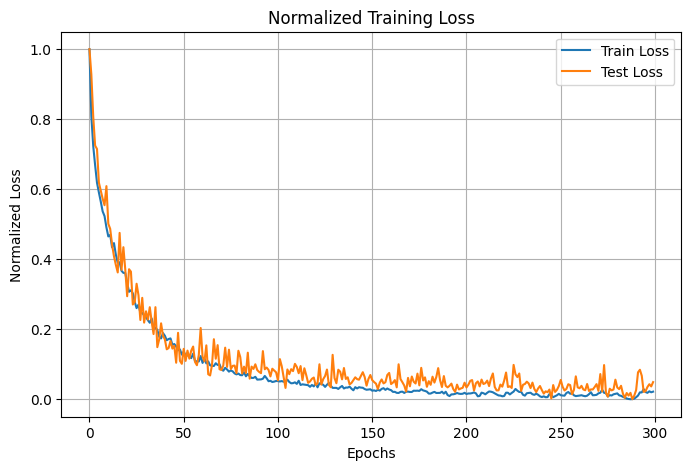

Fold 2


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.913323 | Loss test: 0.798080 | lr = 0.000770676724650948
Epoch 10 | Loss train: 0.459028 | Loss test: 0.545025 | lr = 0.0009382765164422903
Epoch 20 | Loss train: 0.321214 | Loss test: 0.442505 | lr = 0.0009694451176048556
Epoch 30 | Loss train: 0.238372 | Loss test: 0.384878 | lr = 0.0009830942284486462
Epoch 40 | Loss train: 0.204757 | Loss test: 0.339862 | lr = 0.000987507445132229
Epoch 50 | Loss train: 0.155739 | Loss test: 0.303030 | lr = 0.000992759895174734
Epoch 60 | Loss train: 0.131185 | Loss test: 0.295558 | lr = 0.000994859278744038
Epoch 70 | Loss train: 0.114202 | Loss test: 0.291630 | lr = 0.000996102497475881
Epoch 80 | Loss train: 0.095067 | Loss test: 0.285277 | lr = 0.0009972980505064837
Epoch 90 | Loss train: 0.084924 | Loss test: 0.270980 | lr = 0.0009978434688325407
Epoch 100 | Loss train: 0.075538 | Loss test: 0.271470 | lr = 0.000998293561957193
Epoch 110 | Loss train: 0.071267 | Loss test: 0.279590 | lr = 0.000998480974827702
Epoch 120 

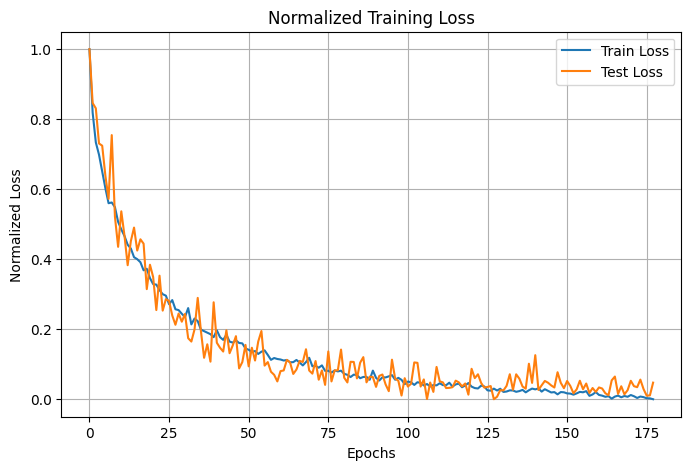

Cross-Validation finished with mean error across 2 subsets = 0.23954084845525878, evaluating final model...


c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.822894 | lr = 0.0004003649211885289
Epoch 10 | Loss train: 0.362871 | lr = 0.0008545985791041246
Epoch 20 | Loss train: 0.244386 | lr = 0.0009321505135578539
Epoch 30 | Loss train: 0.189211 | lr = 0.0009589446431468942
Epoch 40 | Loss train: 0.139115 | lr = 0.0009776629868245275
Epoch 50 | Loss train: 0.113355 | lr = 0.0009851315020923482
Epoch 60 | Loss train: 0.102364 | lr = 0.000987863758863566
Epoch 70 | Loss train: 0.089129 | lr = 0.000990790000410938
Epoch 80 | Loss train: 0.075375 | lr = 0.0009934073511964074
Epoch 90 | Loss train: 0.067749 | lr = 0.0009946715191381207
Epoch 100 | Loss train: 0.058042 | lr = 0.0009960871999615821
Epoch 110 | Loss train: 0.049522 | lr = 0.0009971506320137693
Epoch 120 | Loss train: 0.049341 | lr = 0.0009971714000246428
Epoch 130 | Loss train: 0.039303 | lr = 0.000998204626153393
Epoch 140 | Loss train: 0.037409 | lr = 0.0009983733938394156
Epoch 150 | Loss train: 0.045426 | lr = 0.000997602079631801
Epoch 160 | Loss train:

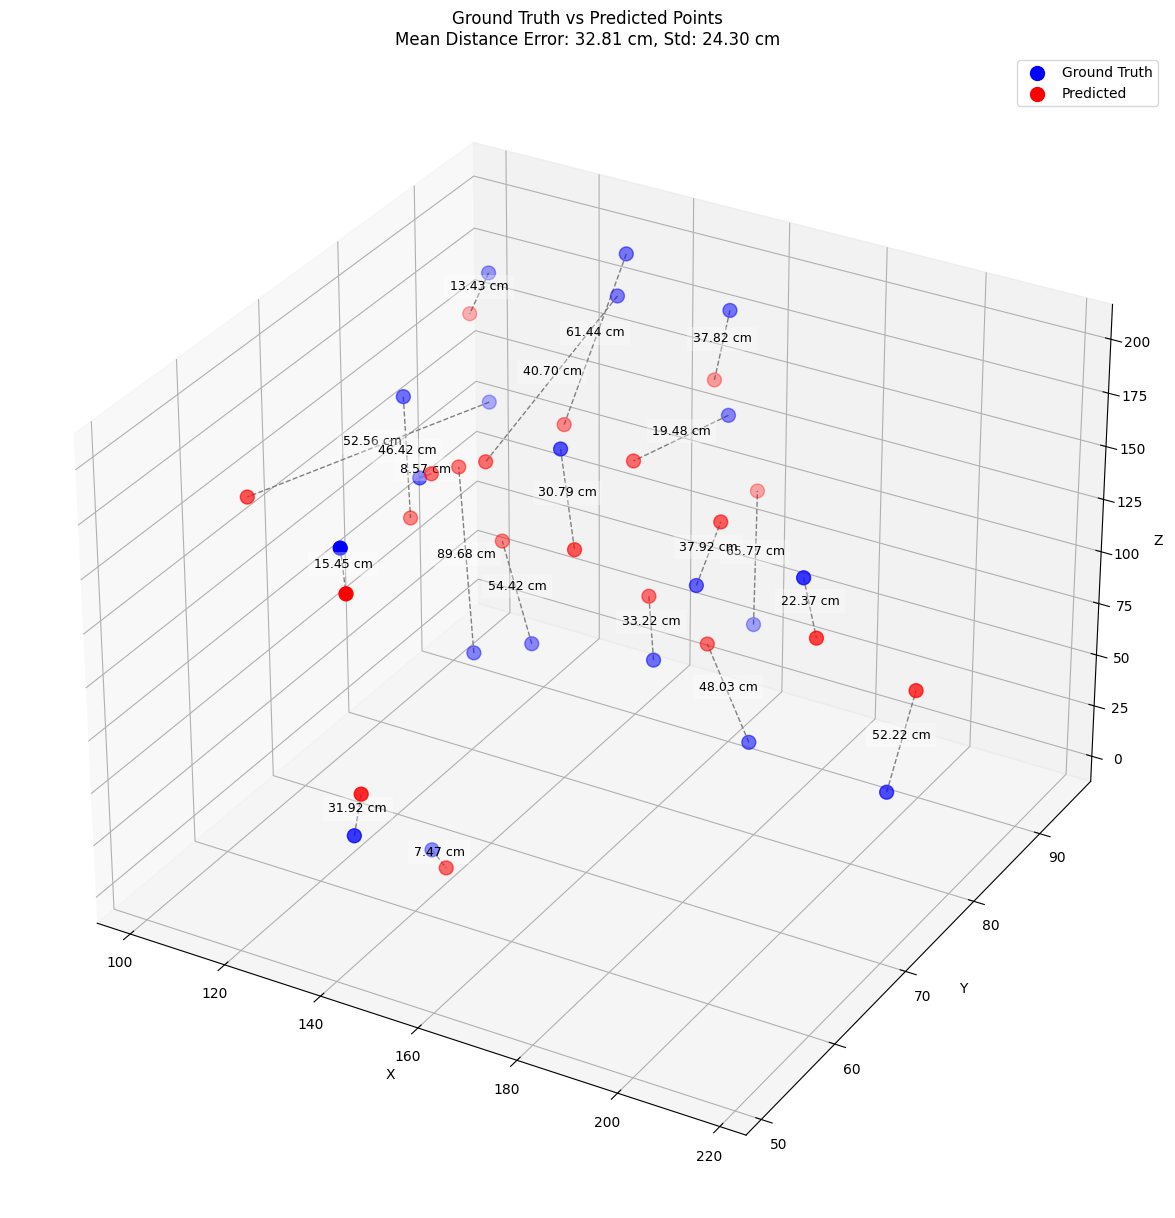

In [21]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam

# Training configuration
num_splits = 2
epochs = 300

# Model parameters
model_params = {
    'input_size': int(input_len / 2),
    'output_size': output_len
}

# Optimizer parameters
optimizer_params = {
    'lr': 1e-3,
    'weight_decay': 1e-4
}

# Scheduler parameters (for CosineAnnealingLR)
scheduler_params = {
    'T_max': 100,
    'eta_min': 1e-5
}

# Early stopping parameters
early_stop_params = {
    'patience': 50,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Perform cross-validation
siameseNetwork, trained_model = cross_validation(
    input_array=info_tensor,
    labels=rfid_label,
    holdout_input=holdout_dataset,
    holdout_label=holdout_labels,
    n_splits=num_splits,
    model=SiameseNetwork,
    model_param=model_params,
    loss_fn=loss_fn,
    optimizer_1=optimizer,
    optimizer_param=optimizer_params,
    scheduler_param=scheduler_params,
    early_stopper_param=early_stop_params,
    epochs=epochs,
    device=device
)


In [23]:
trained_model(torch.Tensor(info_tensor[0,:,4:].reshape(2000,-1).T) , torch.Tensor(info_tensor[0,:,:4].reshape(2000,-1).T))

tensor([[765.6269, 256.0992,  89.9868]], grad_fn=<AddmmBackward0>)

In [24]:
trained_model(torch.Tensor(info_tensor[0,:,:4].reshape(2000,-1).T) , torch.Tensor(info_tensor[0,:,4:].reshape(2000,-1).T))

tensor([[765.6269, 256.0992,  89.9868]], grad_fn=<AddmmBackward0>)

In [25]:
rfid_label[0]

array([117.81756601,  74.67164219,   8.9       ])

Η απόκλιση ευθύνεται στο ότι η είσοδος δεν είναι scaled whatever

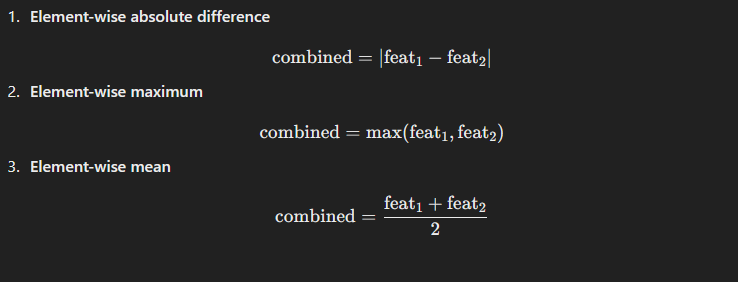